In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import distribute
from tensorflow import keras
from tensorflow.keras import layers  # noqa
from tensorflow.keras.models import Sequential  # noqa
import os
import pathlib

2023-06-13 15:44:06.002837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define dataset location
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)

228813984/228813984 [==============================] - 225s 1us/step


In [3]:
print(data_dir)

/Users/bda/.keras/datasets/flower_photos


In [4]:
# Just show images count
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


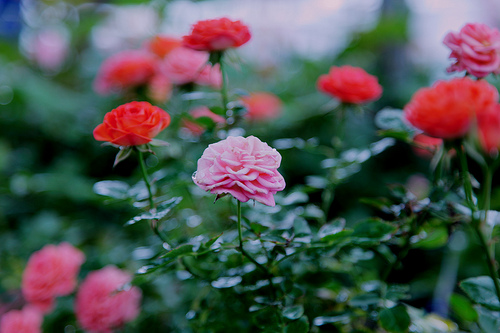

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [6]:
# Define images properties
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Create train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# Just show class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2023-06-13 15:48:07.659698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-06-13 15:48:07.660189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


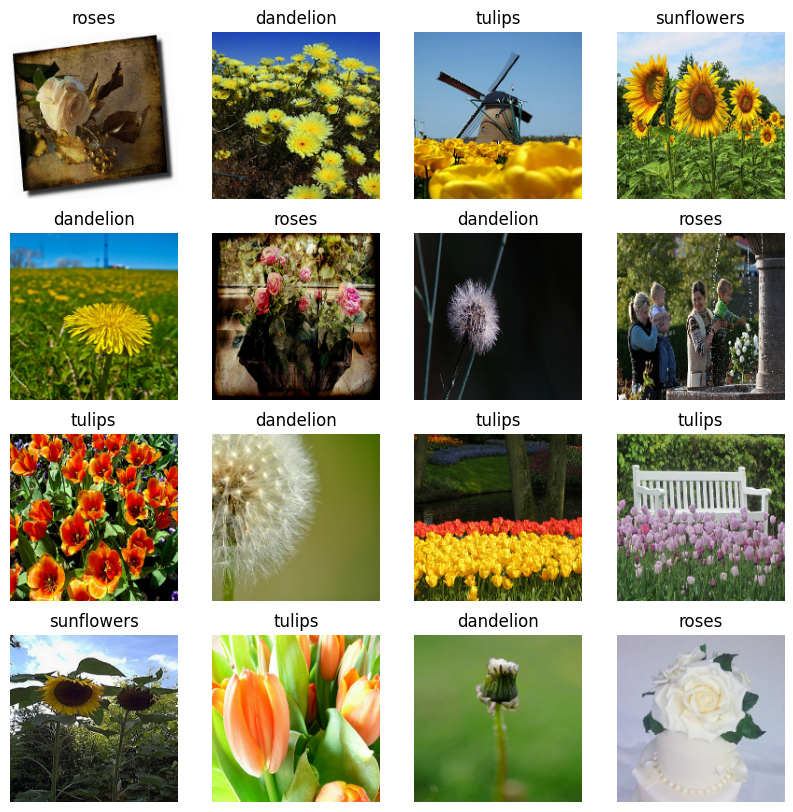

In [10]:
# Just show samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [11]:
# построение набора данных для оценки производительности
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# создание слоя нормализации данных
normalization_layer = layers.Rescaling(1./255)

In [13]:
# создание модели

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,   input_shape=(img_height,   img_width,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

In [14]:
# Compile model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [15]:
# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
# обучение модели

epochs=10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10


2023-06-13 15:48:10.011515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]
2023-06-13 15:48:10.011991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


92/92 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.3992

2023-06-13 15:49:19.353450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]
2023-06-13 15:49:19.353967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [734]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 76s 755ms/step - loss: 1.4013 - accuracy: 0.3992 - val_loss: 1.0735 - val_accuracy: 0.5559
Epoch 2/10
92/92 [==============================] - 54s 587ms/step - loss: 1.0318 - accuracy: 0.5903 - val_loss: 1.0078 - val_accuracy: 0.5926
Epoch 3/10
92/92 [==============================] - 53s 576ms/step - loss: 0.8315 - accuracy: 0.6832 - val_loss: 0.9300 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 48s 523ms/step - loss: 0.6297 - accuracy: 0.7616 - val_loss: 1.0410 - val_accuracy: 0.6144
Epoch 5/10
92/92 [==============================] - 53s 579ms/step - loss: 0.4136 - accuracy: 0.8525 - val_loss: 1.1140 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 53s 574ms/step - loss: 0.2498 - accuracy: 0.9135 - val_loss: 1.4035 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 49s 535ms/step - loss: 0.1379 - accuracy: 0.9561 - val_loss: 1.4984 - val_accuracy: 0.6499
Epoch 8/10

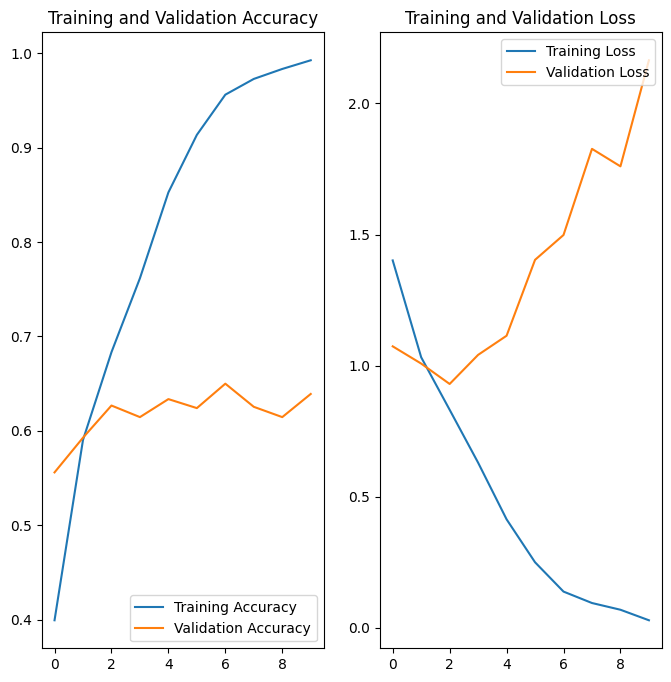

In [17]:
# Print model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [18]:
# доработка модели - расширение данных

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

2023-06-13 15:57:10.648608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-06-13 15:57:10.649048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


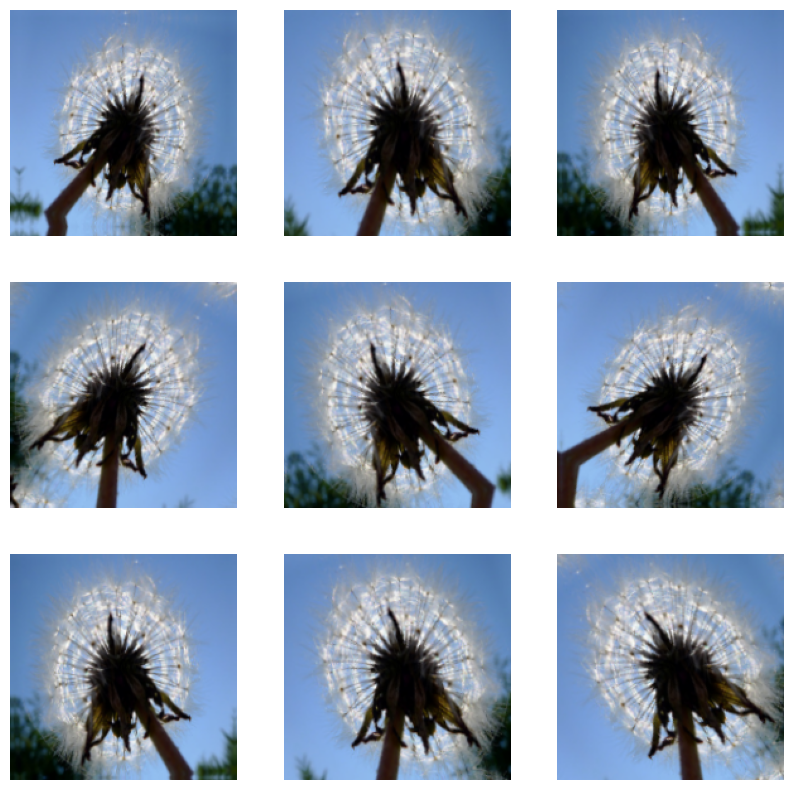

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
# доработка модели - отсев
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

In [21]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy (from_logits=True), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [23]:
# обучение
epochs = 15
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 95s 1s/step - loss: 1.3709 - accuracy: 0.4005 - val_loss: 1.2687 - val_accuracy: 0.4946
Epoch 2/15
92/92 [==============================] - 77s 832ms/step - loss: 1.0629 - accuracy: 0.5722 - val_loss: 1.1277 - val_accuracy: 0.5409
Epoch 3/15
92/92 [==============================] - 81s 877ms/step - loss: 0.9312 - accuracy: 0.6304 - val_loss: 0.9223 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 77s 839ms/step - loss: 0.8625 - accuracy: 0.6611 - val_loss: 0.8431 - val_accuracy: 0.6785
Epoch 5/15
92/92 [==============================] - 76s 827ms/step - loss: 0.8233 - accuracy: 0.6911 - val_loss: 0.8771 - val_accuracy: 0.6553
Epoch 6/15
92/92 [==============================] - 75s 819ms/step - loss: 0.7656 - accuracy: 0.7081 - val_loss: 0.8478 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 67s 727ms/step - loss: 0.7610 - accuracy: 0.7101 - val_loss: 0.9028 - val_accuracy: 0.6485
Ep

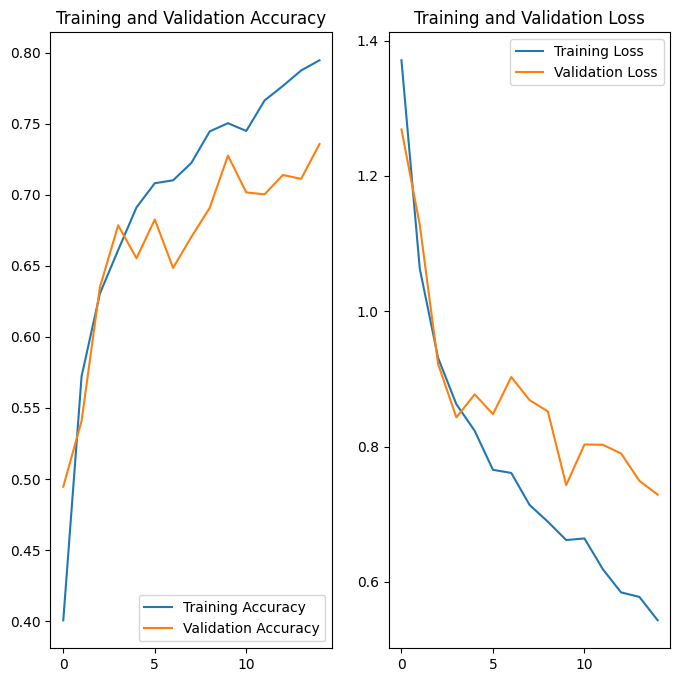

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Try to recognize something
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path   =   tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 168ms/step
This image most likely belongs to sunflowers with a 99.29 percent confidence.


In [29]:

sunflower_path   =   '/Users/bda/.keras/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to roses with a 58.73 percent confidence.


In [30]:

sunflower_path   =   '/Users/bda/.keras/datasets/flower_photos/roses/21347496068_f4d3339607.jpg'


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to roses with a 83.79 percent confidence.
